#                               Modality x emlyon : Final Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3
import time
import math
# custom module
from utils import *

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn import metrics, tree
#import tensorflow as tf
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
import xgboost as xgb
from rulefit import RuleFit
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from alepython import ale_plot

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from math import sqrt
from sklearn.metrics import r2_score

## 0. Preliminary step: Sampled H3s

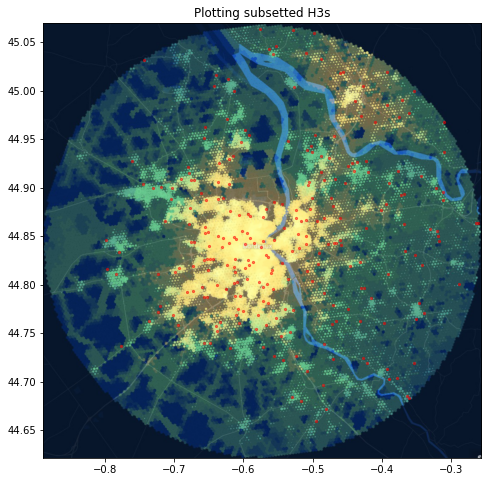

In [2]:
h3s = pd.read_json('modality_h3_258_query.json')
h3s_unique = h3s.h3_id.unique()
lats = [h3.cell_to_latlng(h)[0] for h in h3s_unique]
lngs = [h3.cell_to_latlng(h)[1] for h in h3s_unique]
map2 = plt.imread('pois car.jpeg')

BBox = ((-0.8894721119950215, -0.2569527649506859,
         44.62142605017658, 45.06987256626035))

fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.scatter(lngs, lats, alpha= 0.5, zorder = 1, c='r', s=5)
ax.set_title('Plotting subsetted H3s')
ax.imshow(map2, extent = [BBox[0],BBox[1],BBox[2],BBox[3]], aspect=1.4)

## 1. Exploratory Data Analysis (EDA)

### 1.1 Data exploration

In [3]:
path_to_datasets = "C:\\Users\\gaelc\\OneDrive\\emlyon-dsaib\\Modality\\data\\final_dataset.feather"
df = pd.read_feather(path_to_datasets)
#df = pd.read_feather('final_dataset.feather')

In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [10]:
display_all(df.head().T)

,0,1,2,3,4
start_lat,44.703478,44.703478,44.703478,44.703478,44.703478
start_lng,-0.378127,-0.378127,-0.378127,-0.378127,-0.378127
start_population,35,35,35,35,35
start_jobs,4,4,4,4,4
end_lat,44.703478,44.703478,44.703478,44.685323,44.685323
end_lng,-0.378127,-0.378127,-0.378127,-0.363608,-0.363608
end_population,35,35,35,148,148
end_jobs,4,4,4,33,33
distance_in_meters,0,0,0,3737,3737
valhalla_time,120,120,120,540,540


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199664 entries, 0 to 199663
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   start_lat                199664 non-null  float64
 1   start_lng                199664 non-null  float64
 2   start_population         199664 non-null  int32  
 3   start_jobs               199664 non-null  int32  
 4   start_s1_value           199664 non-null  int32  
 5   start_s2_value           199664 non-null  int32  
 6   start_diff_value         199664 non-null  int32  
 7   end_lat                  199664 non-null  float64
 8   end_lng                  199664 non-null  float64
 9   end_population           199664 non-null  int32  
 10  end_jobs                 199664 non-null  int32  
 11  end_s1_value             199664 non-null  int32  
 12  end_s2_value             199664 non-null  int32  
 13  end_diff_value           199664 non-null  int32  
 14  dist

In [7]:
df.describe()

,start_lat,start_lng,start_population,start_jobs,start_s1_value,start_s2_value,start_diff_value,end_lat,end_lng,end_population,end_jobs,end_s1_value,end_s2_value,end_diff_value,distance_in_meters,valhalla_time,driving_time_in_seconds,driving_time_in_traffic
count,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000,199664.000000
mean,44.852260,-0.539798,179.901079,82.498142,10.612504,26.763883,20.713509,44.852259,-0.539797,179.913905,82.515641,10.612634,26.763277,20.712998,24811.050109,1460.748057,1612.410800,1694.222854
std,0.084187,0.116126,230.083660,193.249814,6.464336,16.932773,12.479046,0.084188,0.116127,230.116776,193.287423,6.464529,16.932763,12.478941,12346.552532,562.965979,599.933322,752.863164
min,44.659559,-0.797753,11.000000,2.000000,1.000000,5.000000,3.000000,44.659559,-0.797753,11.000000,2.000000,1.000000,5.000000,3.000000,0.000000,60.000000,0.000000,0.000000
25%,44.795808,-0.624881,36.000000,4.000000,5.000000,10.000000,10.000000,44.795808,-0.624881,36.000000,4.000000,5.000000,10.000000,10.000000,15465.000000,1200.000000,1199.000000,1169.000000
50%,44.846003,-0.552586,95.000000,12.000000,9.000000,21.000000,16.000000,44.844915,-0.552586,95.000000,12.000000,9.000000,21.000000,16.000000,24269.000000,1500.000000,1608.000000,1614.000000
75%,44.905166,-0.460178,222.000000,75.000000,15.000000,42.000000,31.000000,44.905166,-0.460178,222.000000,75.000000,15.000000,42.000000,31.000000,33389.250000,1800.000000,2011.000000,2118.000000
max,45.063685,-0.260799,1430.000000,1656.000000,30.000000,59.000000,49.000000,45.063685,-0.260799,1430.000000,1656.000000,30.000000,59.000000,49.000000,70111.000000,3600.000000,4564.000000,5005.000000


In [4]:
# drop irrelevant features that were part of the export but does not convey any relevant information
df = df.drop(columns = ['end_s1_value','end_s2_value','start_s1_value','start_s2_value','end_diff_value','start_diff_value'])

#### Check for null values:

In [9]:
df.isna().sum().any()

False

#### Target value distribution analysis:

In [10]:
df['driving_time_in_traffic'].describe()

count    199664.000000
mean       1694.222854
std         752.863164
min           0.000000
25%        1169.000000
50%        1614.000000
75%        2118.000000
max        5005.000000
Name: driving_time_in_traffic, dtype: float64

<AxesSubplot:ylabel='Density'>

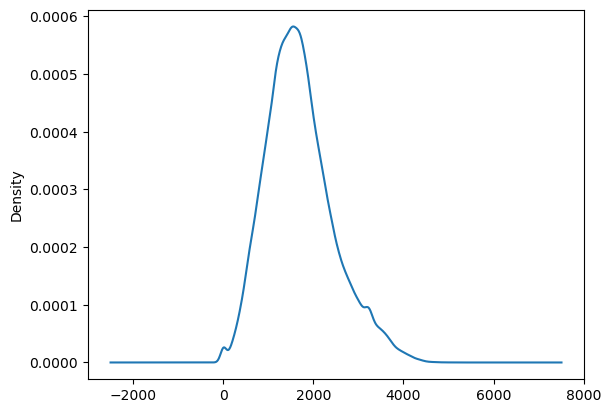

In [11]:
df['driving_time_in_traffic'].plot.kde()

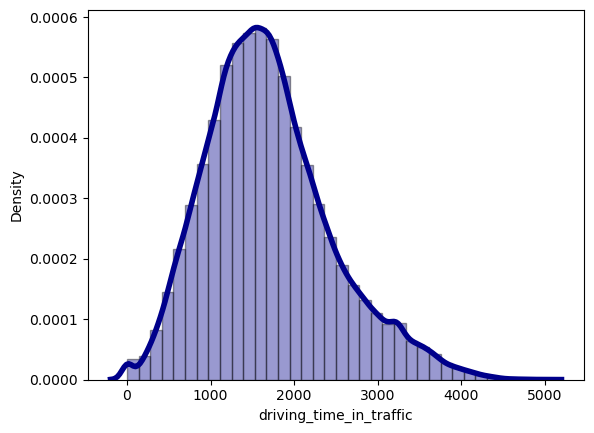

In [12]:
sns.distplot(df['driving_time_in_traffic'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

<AxesSubplot:>

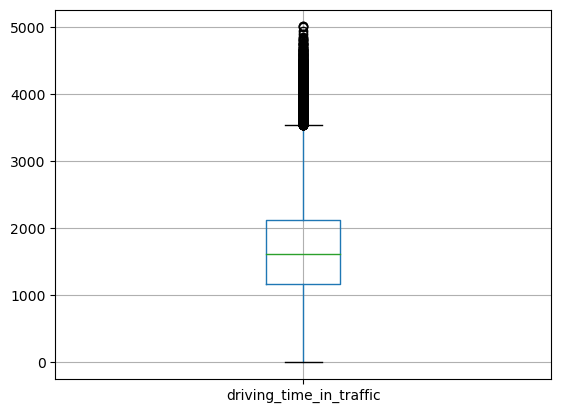

In [13]:
df[['driving_time_in_traffic']].boxplot()

In [14]:
median_DTiT, avg_DTiT = np.median(df.driving_time_in_traffic), np.mean(df.driving_time_in_traffic)

In [15]:
median_DTiT, avg_DTiT

(1614.0, 1694.2228543953843)

##### Interpretation:
- The median value for the dependent variable is 1614.0, and its average is 1694.22.
- The average and median value of close, which suggests that the data may be normally distributed or approximately symmetrically distributed.
- from the above graphs, we can affirm that the target feature follows a rather normal distribution, with its value ranging from 0 to 5005 with a mean of 1694.22 and standard deviation of 752.86.
However, it seems to be slightly skewed to the right (as we can tell from both values above the upper whisker in the boxplot, and the distribution plot from seaborn).

It is due to the fact that we selected more points in the center when building our dataset, since we had limited requests of API, and that the main goal was to capture traffic congestion in the city of Bordeaux.

That is why we don't take any action on the outliers since they are not errors, but genuine information.

Also, there are some 0 values because the start point and destination is the same. but since Valhalla time is not 0, which may be the time to cross an h3 (isochron/hexagon). 
We would like to keep them.

In [10]:
df.groupby('datetime').mean()

,start_lat,start_lng,start_population,start_jobs,end_lat,end_lng,end_population,end_jobs,distance_in_meters,valhalla_time,driving_time_in_seconds,driving_time_in_traffic
datetime,,,,,,,,,,,,
Monday 08AM,44.852255,-0.539800,179.905675,82.497228,44.852257,-0.539801,179.926078,82.523356,24662.070316,1460.750334,1621.412999,2115.231561
Sunday 03PM,44.852268,-0.539789,179.894096,82.492314,44.852256,-0.539797,179.916756,82.520022,24972.595258,1460.771138,1605.871197,1509.851257
Thursday 11PM,44.852259,-0.539804,179.903465,82.504883,44.852262,-0.539794,179.898882,82.503546,24798.499129,1460.722700,1609.947578,1457.565569


In [20]:
med_dist = np.median(df.distance_in_meters)
med_val = np.median(df.valhalla_time)
print(med_dist)
print(med_val)

24269.0
1500.0


In [12]:
# Tried to drop the routes with 0 distance
#df = df[df["distance_in_meters"]!=0]

In [16]:
df.shape

(199664, 13)

#### Pearson Correlation Matrix

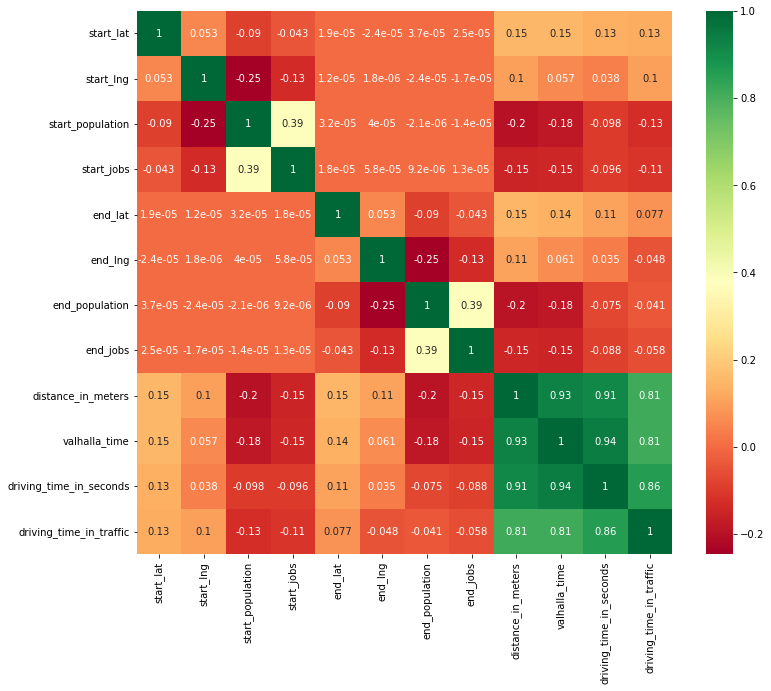

In [15]:
import seaborn as sns

fig, axes = plt.subplots(1, 1, figsize=(12, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

<AxesSubplot:xlabel='distance_in_meters', ylabel='valhalla_time'>

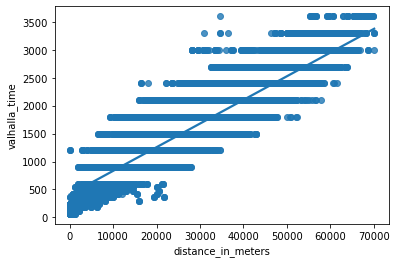

In [16]:
sns.regplot(x='distance_in_meters', y='valhalla_time', data=df)

In [17]:
df.distance_in_meters[10:20]

10     3042
11     3042
12    12452
13    12452
14    12452
15    14244
16    14244
17    14244
18    15910
19    15910
Name: distance_in_meters, dtype: int64

- denotes a positive relationship between valhalla_time and the distance_in_meters, which make sense since the more 
- distance you have to cover the more time you will spent to reach your destination. Since traffic congestion is not
- taken into account in the valhalla algorithm, it makes sense that both variables are strongly correlated.

<AxesSubplot:xlabel='distance_in_meters', ylabel='driving_time_in_traffic'>

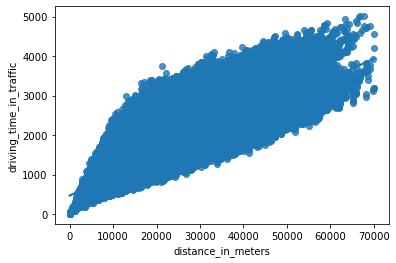

In [18]:
sns.regplot(x='distance_in_meters', y='driving_time_in_traffic', data=df)

- denotes a positive relationship between driving_time_in_traffic and the distance_in_meters.
- However, as the correlation is less between these two parameters, so the graph is more scattered and the dependency is less between the two.  In fact, we can clearly notice that there is a higher variance, the data points spread sharply until 2000 distance meters then remains quite steady. 

- First hypothesis: this distribution denotes the strong impact that can have traffic congestion, even on relatively  small routes. 

- Second hypothesis: traffic congestion seems to happen mainly withing specific areas: in fact, the variance doesnt  change when the route is higher than 3000 meters. So once it has been captured somewhere (probably in the city center, hot spot, or tolls), the driving time looks more linear (and nso the traffic is smoother).

### 1.2 Feature engineering

In [21]:
df.datetime[1]

'Thursday 11PM'

In [5]:
# Parse datetime strings
df['date_time'] = pd.to_datetime(df['datetime'], format='%A %I%p')

# Extract hour and day of week information
df['Hours'] = df['date_time'].dt.hour

# extract day of the week
df['day_of_week'] = df['datetime'].str.split(' ', expand=True)[0]

# create week_end column
df['week_end'] = df['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# drop date_time (which convey wrong information by generating false year and month)
df.drop(columns=['date_time'], inplace=True)

#drop datetime because it conveys the same information as "Hours" and "day_of_week"
df.drop(columns=['datetime'], inplace=True)

In [18]:
df[["week_end","Hours", "day_of_week"]]

,week_end,Hours,day_of_week
0,0,8,Monday
1,0,23,Thursday
2,1,15,Sunday
3,0,8,Monday
4,0,23,Thursday
...,...,...,...
199659,1,15,Sunday
199660,0,23,Thursday
199661,1,15,Sunday
199662,0,23,Thursday


Note 1: To compute ‘Hours’ in a fast way from the “datetime”, we parsed the datetime string into a date time format and then extracted directly the hour using the .dt.hour method. However, “date_time” generated false year and month information since it was not specified in the “datetime” column, so that is the reason why we dropped it.
Also, we did not compute the actual month and year because we are working with a sample that covers only a short period of time due to the limited API requests. Then, adding these elements would only bias the model because it is not representative.


Note 2: "day_of_week" will be later converted to numerical values when we use the proc custom function in the next steps.

Note 3: We could have also add the following features:
a feature computing whether the date is occurring during holidays or not,
a feature computing the weather for each day (since the weather could positively or negatively impact traffic congestion).

However, our dataset does not cover a sufficient period of time to include the seasonality. Besides, the weather is hardly predictable in advance, we would have to collect near real time data to make predictions that are a good representation of reality. Otherwise, this would just add an extra bias.

Also, Modality is not intended to make predictions in real time, the main goal being to offer simulations to pilot the mobility-mix of all territories.


### 1.3 Feature selection

In [6]:
df_backup = copy.deepcopy(df)

In [12]:
# exclude columns: 'end_s1_value','end_s2_value','start_s1_value','start_s2_value','end_diff_value','start_diff_value'
df = df.drop(columns = ['driving_time_in_seconds'])

#df = df.iloc[:, [0, 1, 7, 8, 14, 15, 16, 17]]
display_all(df.head().T)

,0,1,2,3,4
start_lat,44.703478,44.703478,44.703478,44.703478,44.703478
start_lng,-0.378127,-0.378127,-0.378127,-0.378127,-0.378127
start_population,35,35,35,35,35
start_jobs,4,4,4,4,4
end_lat,44.703478,44.703478,44.703478,44.685323,44.685323
end_lng,-0.378127,-0.378127,-0.378127,-0.363608,-0.363608
end_population,35,35,35,148,148
end_jobs,4,4,4,33,33
distance_in_meters,0,0,0,3737,3737
valhalla_time,120,120,120,540,540


We have already removed the features that had a too high correlation that were irrelevant for our prediction (in the first steps of the notebook) i.e 'end_s1_value','end_s2_value','start_s1_value','start_s2_value','end_diff_value','start_diff_value'

We also removed 'driving_time_in_seconds', which is highly correlated to 'vallahalla_driving_time'. They convey almost the 
same information: google convey the practical/historical time without traffic, where valhallah convey the theoritcal time.
It does not make much sense to keep it in the dataset because 'driving_time_in_seconds' is also requested from google, for the company, they will not have this data (since we used limited requested from Google API to get this data).

### 1.4 Data Standardization and preparation for modeling

In [13]:
X, y, nas = proc_df(df, 'driving_time_in_traffic') 

the proc function converts every non-numerical values into continuous values, split the dataset in two:
- X, which contains the independent variables (features),
- Y, which contains the dependent variable (target)

In [22]:
X.dtypes

start_lat             float64
start_lng             float64
start_population        int32
start_jobs              int32
end_lat               float64
end_lng               float64
end_population          int32
end_jobs                int32
distance_in_meters      int64
valhalla_time           int64
Hours                   int64
day_of_week              int8
week_end                int64
dtype: object

In [23]:
X

,start_lat,start_lng,start_population,start_jobs,end_lat,end_lng,end_population,end_jobs,distance_in_meters,valhalla_time,Hours,day_of_week,week_end
0,44.703478,-0.378127,35,4,44.703478,-0.378127,35,4,0,120,8,1,0
1,44.703478,-0.378127,35,4,44.703478,-0.378127,35,4,0,120,23,3,0
2,44.703478,-0.378127,35,4,44.703478,-0.378127,35,4,0,120,15,2,1
3,44.703478,-0.378127,35,4,44.685323,-0.363608,148,33,3737,540,8,1,0
4,44.703478,-0.378127,35,4,44.685323,-0.363608,148,33,3737,540,23,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199659,44.881448,-0.470057,14,2,44.734478,-0.619853,18,2,25408,1500,15,2,1
199660,44.947327,-0.603537,329,326,44.806049,-0.536094,107,25,29471,1800,23,3,0
199661,44.947327,-0.603537,329,326,44.806049,-0.536094,107,25,29471,1800,15,2,1
199662,44.947327,-0.603537,329,326,44.907479,-0.675417,239,4,9319,900,23,3,0


In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
scaler.fit(X)
X_trans = scaler.transform(X)

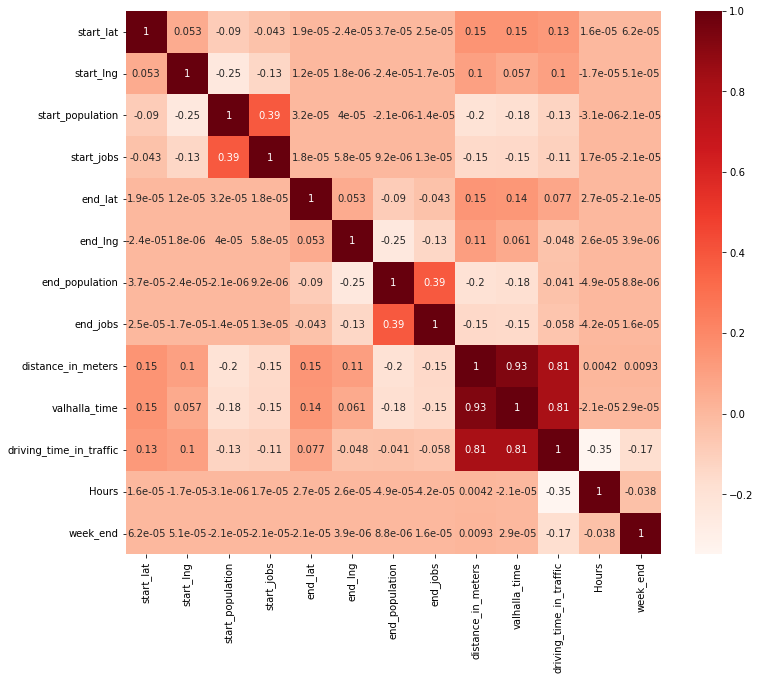

In [28]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

While we will mainly use ensemble tree models, we choose to standardize data. It will be used only for KNN because it
is a model based on distances so it makes sense to standardize data.

However, concerning ensemble tree models, the performance was performing worse using scaled data, so we won't use it for
these models. 

It is not surprising considering that Random Forest and Boosted Tree models are not affected by data dimensionality 
because they are ensemble methods that utilize multiple decision trees to make predictions.

In both cases, the use of subsets of features and training multiple trees on different subsets of the data helps to 
reduce the impact of high dimensionality on the models' performance. 

However, it is still important to carefully select the most relevant features for training these models to ensure good 
performance and avoid overfitting.

### 1.5 PCA

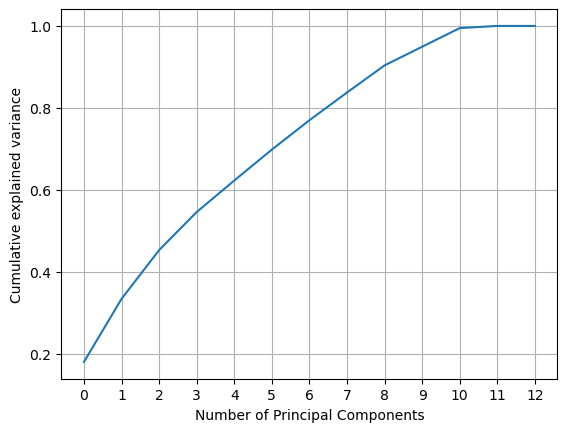

In [16]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plot the explained variance

df_pca = copy.deepcopy(X)

scalers = StandardScaler()
Xscale = scalers.fit_transform(df_pca)
pca_var = PCA(n_components=df_pca.shape[1])
X_pca = pca_var.fit_transform(Xscale)


# Rotate dataset along higher variance axes
plt.plot(np.cumsum(pca_var.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative explained variance');
plt.grid(True)
_=plt.xticks([i for i in range(0,df_pca.shape[1])])

11 out of 13 features explains nearly 100% of the variance, which is good because it means that we don’t really have irrelevant features anymore to be dropped, every feature seems to convey a unique information. 

In [17]:
X.shape

(199664, 13)

## 2. Modeling

In [29]:
train_cats(df)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)

In [31]:
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans, y, test_size = .2, random_state = 1)

### 2.1 Model choosing

In [32]:
from sklearn.metrics import classification_report
def modeltesting(algorithm, X_train, y_train, X_test, y_test):
    model = algorithm()
    %time model.fit(X_train, y_train)
    y_train_pred =model.predict(X_train) ##Predict train result
    y_test_pred =model.predict(X_test) ##Predict test result
    
    print('')
    print("Train Results :")
    print(50 * '-')
    print("Root mean squared error: ", sqrt(mean_squared_error(y_train, y_train_pred)))
    print("R-squared: ", r2_score(y_train, y_train_pred))
    print(50 * '-')
    print("Test Results :")
    print(50 * '-')
    print("Root mean squared error: ", sqrt(mean_squared_error(y_test, y_test_pred)))
    print("R-squared: ", r2_score(y_test, y_test_pred))


#### 2.1.1 Ridge regression

In [33]:
modeltesting(Ridge,X_train, y_train, X_test, y_test)

CPU times: total: 15.6 ms
Wall time: 90.5 ms

Train Results :
--------------------------------------------------
Root mean squared error:  268.99420873573706
R-squared:  0.8720130996231426
--------------------------------------------------
Test Results :
--------------------------------------------------
Root mean squared error:  270.34250526458425
R-squared:  0.8723594618472691


#### 2.1.2 Lasso regression

In [34]:
modeltesting(Lasso,X_train, y_train, X_test, y_test)

CPU times: total: 141 ms
Wall time: 531 ms

Train Results :
--------------------------------------------------
Root mean squared error:  269.5540580417008
R-squared:  0.871479794890213
--------------------------------------------------
Test Results :
--------------------------------------------------
Root mean squared error:  270.9990640034294
R-squared:  0.8717387287217824


#### 2.1.3 KNN

In [35]:
modeltesting(KNeighborsRegressor,X_train_trans, y_train_trans, X_test_trans, y_test_trans)

CPU times: total: 656 ms
Wall time: 929 ms

Train Results :
--------------------------------------------------
Root mean squared error:  93.34236219691984
R-squared:  0.9845887723469797
--------------------------------------------------
Test Results :
--------------------------------------------------
Root mean squared error:  117.0388059770138
R-squared:  0.9760767750810386


#### 2.1.4 Random Forest

In [36]:
modeltesting(RandomForestRegressor,X_train, y_train, X_test, y_test)

CPU times: total: 1min 22s
Wall time: 2min 26s

Train Results :
--------------------------------------------------
Root mean squared error:  29.556690673411687
R-squared:  0.9984547766071085
--------------------------------------------------
Test Results :
--------------------------------------------------
Root mean squared error:  78.0510375150983
R-squared:  0.9893605955348034


#### 2.1.5 LightGBM

In [37]:
modeltesting(LGBMRegressor,X_train, y_train, X_test, y_test)

CPU times: total: 5.83 s
Wall time: 1.27 s

Train Results :
--------------------------------------------------
Root mean squared error:  106.35039819711801
R-squared:  0.9799941088322232
--------------------------------------------------
Test Results :
--------------------------------------------------
Root mean squared error:  107.69177577862402
R-squared:  0.9797453363804307


#### 2.1.6 Catboost

In [38]:
modeltesting(CatBoostRegressor,X_train, y_train, X_test, y_test)

Learning rate set to 0.091267
0:	learn: 694.8190160	total: 169ms	remaining: 2m 48s
1:	learn: 642.2146240	total: 184ms	remaining: 1m 31s
2:	learn: 595.5419296	total: 199ms	remaining: 1m 6s
3:	learn: 552.7417413	total: 213ms	remaining: 53.1s
4:	learn: 514.4940737	total: 228ms	remaining: 45.3s
5:	learn: 479.7025140	total: 243ms	remaining: 40.3s
6:	learn: 448.4039930	total: 257ms	remaining: 36.5s
7:	learn: 420.0599768	total: 272ms	remaining: 33.7s
8:	learn: 394.4530814	total: 286ms	remaining: 31.5s
9:	learn: 371.6314624	total: 299ms	remaining: 29.6s
10:	learn: 350.9260427	total: 313ms	remaining: 28.2s
11:	learn: 331.9554102	total: 328ms	remaining: 27s
12:	learn: 315.6615197	total: 342ms	remaining: 26s
13:	learn: 300.7380311	total: 357ms	remaining: 25.1s
14:	learn: 287.3530668	total: 371ms	remaining: 24.4s
15:	learn: 275.6321531	total: 386ms	remaining: 23.8s
16:	learn: 264.9190703	total: 402ms	remaining: 23.2s
17:	learn: 255.7325022	total: 417ms	remaining: 22.7s
18:	learn: 247.2309883	total

165:	learn: 122.4684711	total: 2.52s	remaining: 12.6s
166:	learn: 122.2610796	total: 2.53s	remaining: 12.6s
167:	learn: 122.0364979	total: 2.54s	remaining: 12.6s
168:	learn: 121.8480038	total: 2.56s	remaining: 12.6s
169:	learn: 121.6577084	total: 2.58s	remaining: 12.6s
170:	learn: 121.4541556	total: 2.59s	remaining: 12.6s
171:	learn: 121.2522409	total: 2.61s	remaining: 12.5s
172:	learn: 121.1401733	total: 2.62s	remaining: 12.5s
173:	learn: 120.9996620	total: 2.64s	remaining: 12.5s
174:	learn: 120.7934833	total: 2.65s	remaining: 12.5s
175:	learn: 120.5942442	total: 2.67s	remaining: 12.5s
176:	learn: 120.3594694	total: 2.68s	remaining: 12.5s
177:	learn: 120.0405738	total: 2.69s	remaining: 12.4s
178:	learn: 119.8942917	total: 2.71s	remaining: 12.4s
179:	learn: 119.7456483	total: 2.72s	remaining: 12.4s
180:	learn: 119.5525490	total: 2.74s	remaining: 12.4s
181:	learn: 119.3999100	total: 2.75s	remaining: 12.4s
182:	learn: 119.2074229	total: 2.77s	remaining: 12.4s
183:	learn: 119.0561264	tota

329:	learn: 101.7918985	total: 4.88s	remaining: 9.92s
330:	learn: 101.6657491	total: 4.9s	remaining: 9.9s
331:	learn: 101.5764259	total: 4.91s	remaining: 9.89s
332:	learn: 101.4611248	total: 4.93s	remaining: 9.87s
333:	learn: 101.3609764	total: 4.94s	remaining: 9.86s
334:	learn: 101.3044867	total: 4.96s	remaining: 9.84s
335:	learn: 101.2217266	total: 4.97s	remaining: 9.82s
336:	learn: 101.1219375	total: 4.99s	remaining: 9.81s
337:	learn: 101.0177321	total: 5s	remaining: 9.79s
338:	learn: 100.9662250	total: 5.01s	remaining: 9.78s
339:	learn: 100.8930853	total: 5.03s	remaining: 9.76s
340:	learn: 100.8007744	total: 5.04s	remaining: 9.75s
341:	learn: 100.6547516	total: 5.06s	remaining: 9.73s
342:	learn: 100.5711580	total: 5.07s	remaining: 9.72s
343:	learn: 100.4566002	total: 5.09s	remaining: 9.71s
344:	learn: 100.3792515	total: 5.11s	remaining: 9.69s
345:	learn: 100.2959547	total: 5.12s	remaining: 9.68s
346:	learn: 100.2089047	total: 5.14s	remaining: 9.67s
347:	learn: 100.1146102	total: 5.

492:	learn: 91.1314958	total: 7.25s	remaining: 7.45s
493:	learn: 91.0897369	total: 7.26s	remaining: 7.44s
494:	learn: 91.0527877	total: 7.28s	remaining: 7.42s
495:	learn: 91.0066271	total: 7.29s	remaining: 7.41s
496:	learn: 90.9357524	total: 7.31s	remaining: 7.39s
497:	learn: 90.8606032	total: 7.32s	remaining: 7.38s
498:	learn: 90.8302363	total: 7.33s	remaining: 7.36s
499:	learn: 90.7581845	total: 7.35s	remaining: 7.35s
500:	learn: 90.7156603	total: 7.36s	remaining: 7.33s
501:	learn: 90.6773933	total: 7.38s	remaining: 7.32s
502:	learn: 90.6466999	total: 7.39s	remaining: 7.3s
503:	learn: 90.6072734	total: 7.41s	remaining: 7.29s
504:	learn: 90.5492650	total: 7.42s	remaining: 7.27s
505:	learn: 90.4967460	total: 7.43s	remaining: 7.26s
506:	learn: 90.4355246	total: 7.45s	remaining: 7.24s
507:	learn: 90.3856097	total: 7.46s	remaining: 7.23s
508:	learn: 90.3370755	total: 7.48s	remaining: 7.21s
509:	learn: 90.3105278	total: 7.49s	remaining: 7.2s
510:	learn: 90.2627353	total: 7.51s	remaining: 7

654:	learn: 84.3743276	total: 9.58s	remaining: 5.05s
655:	learn: 84.3390430	total: 9.6s	remaining: 5.03s
656:	learn: 84.2956232	total: 9.61s	remaining: 5.02s
657:	learn: 84.2412764	total: 9.63s	remaining: 5s
658:	learn: 84.2198043	total: 9.64s	remaining: 4.99s
659:	learn: 84.1939716	total: 9.66s	remaining: 4.97s
660:	learn: 84.1736734	total: 9.67s	remaining: 4.96s
661:	learn: 84.1578458	total: 9.69s	remaining: 4.95s
662:	learn: 84.1255022	total: 9.7s	remaining: 4.93s
663:	learn: 84.0934585	total: 9.71s	remaining: 4.92s
664:	learn: 84.0447255	total: 9.73s	remaining: 4.9s
665:	learn: 84.0128107	total: 9.74s	remaining: 4.89s
666:	learn: 83.9700090	total: 9.76s	remaining: 4.87s
667:	learn: 83.9413519	total: 9.77s	remaining: 4.86s
668:	learn: 83.9187359	total: 9.79s	remaining: 4.84s
669:	learn: 83.8845018	total: 9.8s	remaining: 4.83s
670:	learn: 83.8577875	total: 9.81s	remaining: 4.81s
671:	learn: 83.8223321	total: 9.83s	remaining: 4.8s
672:	learn: 83.7772382	total: 9.85s	remaining: 4.78s
6

818:	learn: 79.2824139	total: 11.9s	remaining: 2.64s
819:	learn: 79.2466706	total: 12s	remaining: 2.63s
820:	learn: 79.2243368	total: 12s	remaining: 2.61s
821:	learn: 79.2082376	total: 12s	remaining: 2.6s
822:	learn: 79.1853901	total: 12s	remaining: 2.58s
823:	learn: 79.1396103	total: 12s	remaining: 2.57s
824:	learn: 79.1118010	total: 12s	remaining: 2.55s
825:	learn: 79.0772041	total: 12.1s	remaining: 2.54s
826:	learn: 79.0341762	total: 12.1s	remaining: 2.52s
827:	learn: 79.0092985	total: 12.1s	remaining: 2.51s
828:	learn: 78.9669371	total: 12.1s	remaining: 2.5s
829:	learn: 78.9504319	total: 12.1s	remaining: 2.48s
830:	learn: 78.9210571	total: 12.1s	remaining: 2.46s
831:	learn: 78.9023955	total: 12.1s	remaining: 2.45s
832:	learn: 78.8782509	total: 12.2s	remaining: 2.44s
833:	learn: 78.8581313	total: 12.2s	remaining: 2.42s
834:	learn: 78.8356341	total: 12.2s	remaining: 2.41s
835:	learn: 78.8047912	total: 12.2s	remaining: 2.39s
836:	learn: 78.7726854	total: 12.2s	remaining: 2.38s
837:	le

980:	learn: 75.2568628	total: 14.3s	remaining: 277ms
981:	learn: 75.2474883	total: 14.3s	remaining: 262ms
982:	learn: 75.2367517	total: 14.3s	remaining: 248ms
983:	learn: 75.2019726	total: 14.3s	remaining: 233ms
984:	learn: 75.1611661	total: 14.4s	remaining: 219ms
985:	learn: 75.1426414	total: 14.4s	remaining: 204ms
986:	learn: 75.1322953	total: 14.4s	remaining: 189ms
987:	learn: 75.1197684	total: 14.4s	remaining: 175ms
988:	learn: 75.0990791	total: 14.4s	remaining: 160ms
989:	learn: 75.0810994	total: 14.4s	remaining: 146ms
990:	learn: 75.0551275	total: 14.4s	remaining: 131ms
991:	learn: 75.0076109	total: 14.5s	remaining: 117ms
992:	learn: 74.9963292	total: 14.5s	remaining: 102ms
993:	learn: 74.9700134	total: 14.5s	remaining: 87.4ms
994:	learn: 74.9519907	total: 14.5s	remaining: 72.8ms
995:	learn: 74.9342989	total: 14.5s	remaining: 58.3ms
996:	learn: 74.9205202	total: 14.5s	remaining: 43.7ms
997:	learn: 74.8954737	total: 14.5s	remaining: 29.1ms
998:	learn: 74.8642247	total: 14.6s	remai

#### 2.1.7 XGBoost

In [39]:
modeltesting(XGBRegressor,X_train, y_train, X_test, y_test)

CPU times: total: 32.3 s
Wall time: 7.39 s

Train Results :
--------------------------------------------------
Root mean squared error:  80.82262196471167
R-squared:  0.9884456496565113
--------------------------------------------------
Test Results :
--------------------------------------------------
Root mean squared error:  85.78863317810503
R-squared:  0.9871465576075548


### 2.2 Final model

#### 2.2.1 XGBoost

In [105]:
xgb_model = xgb.XGBRegressor(max_depth=10, n_jobs=4, objective='reg:squarederror',
                    random_state=42, n_estimators=150).\
                    fit(X_train, y_train,
                    eval_set=[(X_train, y_train),(X_test, y_test)],
                    eval_metric='rmse')

[0]	validation_0-rmse:1303.78238	validation_1-rmse:1306.49626
[1]	validation_0-rmse:920.10126	validation_1-rmse:922.81224
[2]	validation_0-rmse:652.84187	validation_1-rmse:655.96391
[3]	validation_0-rmse:467.03962	validation_1-rmse:470.50425
[4]	validation_0-rmse:338.83987	validation_1-rmse:342.81142
[5]	validation_0-rmse:251.21662	validation_1-rmse:255.89154
[6]	validation_0-rmse:192.36027	validation_1-rmse:197.92730
[7]	validation_0-rmse:153.49388	validation_1-rmse:159.89122
[8]	validation_0-rmse:128.47776	validation_1-rmse:135.79152
[9]	validation_0-rmse:112.61059	validation_1-rmse:120.77809
[10]	validation_0-rmse:102.50135	validation_1-rmse:111.26655
[11]	validation_0-rmse:95.41571	validation_1-rmse:104.56871
[12]	validation_0-rmse:90.83764	validation_1-rmse:100.33378
[13]	validation_0-rmse:86.64964	validation_1-rmse:96.49344
[14]	validation_0-rmse:83.63819	validation_1-rmse:93.80579
[15]	validation_0-rmse:81.42940	validation_1-rmse:91.81684
[16]	validation_0-rmse:79.04358	validati

[138]	validation_0-rmse:31.53978	validation_1-rmse:57.89844
[139]	validation_0-rmse:31.35812	validation_1-rmse:57.81996
[140]	validation_0-rmse:31.23418	validation_1-rmse:57.76900
[141]	validation_0-rmse:31.10265	validation_1-rmse:57.70931
[142]	validation_0-rmse:31.04299	validation_1-rmse:57.69586
[143]	validation_0-rmse:31.00423	validation_1-rmse:57.68216
[144]	validation_0-rmse:30.94002	validation_1-rmse:57.66473
[145]	validation_0-rmse:30.73183	validation_1-rmse:57.55964
[146]	validation_0-rmse:30.62995	validation_1-rmse:57.51355
[147]	validation_0-rmse:30.52375	validation_1-rmse:57.46128
[148]	validation_0-rmse:30.36911	validation_1-rmse:57.38806
[149]	validation_0-rmse:30.27372	validation_1-rmse:57.36811


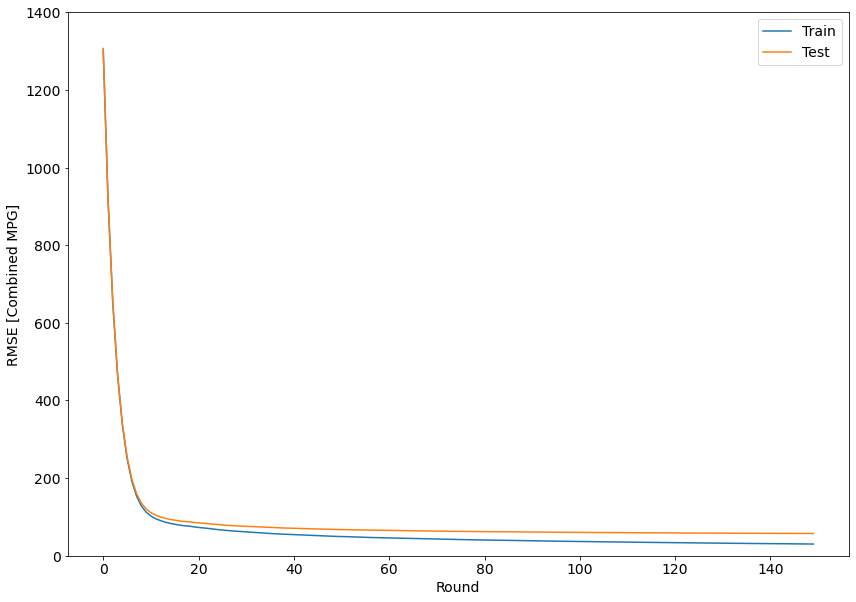

In [106]:
plt.figure(figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.plot(xgb_model.evals_result()['validation_0']['rmse'])
plt.plot(xgb_model.evals_result()['validation_1']['rmse'])
plt.ylabel('RMSE [Combined MPG]', fontsize=14)
plt.ylim([0, 1400])
plt.xlabel('Round', fontsize=14)
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [107]:
y_train_xgb_pred = xgb_model.predict(X_train)
y_test_xgb_pred = xgb_model.predict(X_test)
RMSE_xgb_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_xgb_pred))
RMSE_xgb_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_xgb_pred))
R2_xgb_test = metrics.r2_score(y_test, y_test_xgb_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_xgb_train, RMSE_xgb_test, R2_xgb_test))

RMSE_train: 30.2737	RMSE_test: 57.3681	r2: 0.9943


#### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

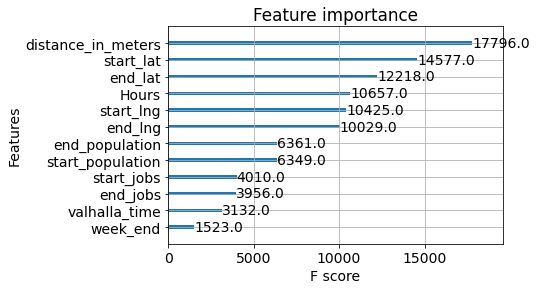

In [108]:
xgb.plot_importance(xgb_model)

#### 2.2.2 Catboost

In [109]:
model = CatBoostRegressor(
    n_estimators = 500,
    random_seed = 42,
    loss_function = 'RMSE',
    #allow_writing_files = False,
    logging_level = 'Silent',
    max_depth=10
)

In [110]:
%time model.fit(X_train, y_train)

CPU times: total: 8.64 s
Wall time: 10.8 s


In [111]:
y_train_cat_pred = model.predict(X_train)
y_test_cat_pred = model.predict(X_test)
RMSE_cat_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_cat_pred))
RMSE_cat_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_cat_pred))
R2_cat_test = metrics.r2_score(y_test, y_test_cat_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_cat_train, RMSE_cat_test, R2_cat_test))

RMSE_train: 48.0048	RMSE_test: 55.4465	r2: 0.9946


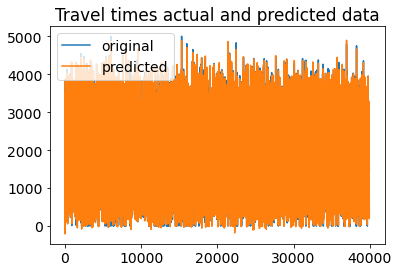

In [112]:
#plot the prediction
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_cat_pred, label="predicted")

plt.title("Travel times actual and predicted data")

plt.legend()
plt.show()

In [113]:
model.save_model("model")

#### Feature importance

In [114]:
def rf_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance

In [115]:
feat_importance = rf_feat_importance(model, X_train)
feat_importance[:20]

,cols,imp
10,Hours,30.605719
8,distance_in_meters,15.781976
9,valhalla_time,12.717986
11,day_of_week,12.151702
5,end_lng,9.695326
1,start_lng,6.868564
0,start_lat,3.778306
4,end_lat,3.412481
6,end_population,1.922359
2,start_population,1.434169


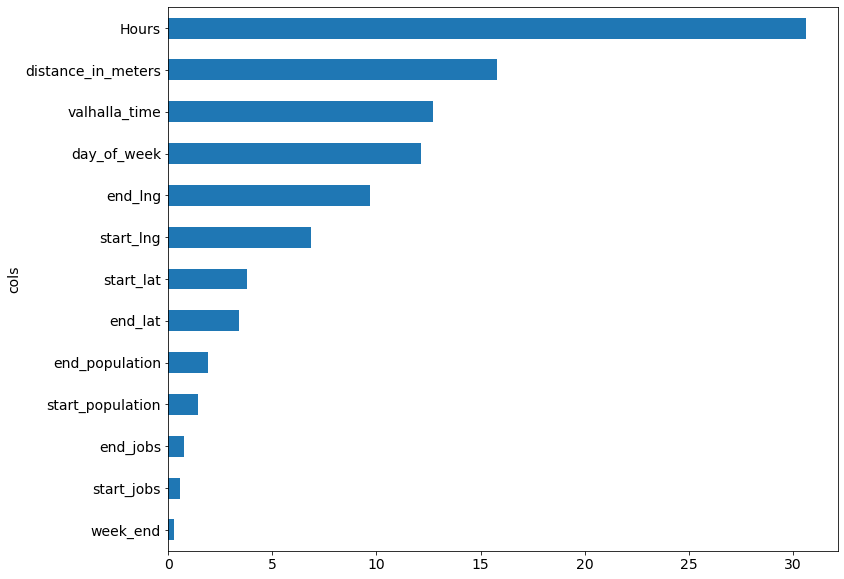

In [116]:
barh = feat_importance[:30].plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

## 3. Interpreting SHAP Summary

In [117]:
shap_cat_explainer = shap.TreeExplainer(model)

In [118]:
shap_cat_values_train = shap_cat_explainer.shap_values(X_train)
print(shap_cat_values_train.shape)
shap_cat_values_test = shap_cat_explainer.shap_values(X_test)
print(shap_cat_values_test.shape)

(159731, 13)
(39933, 13)


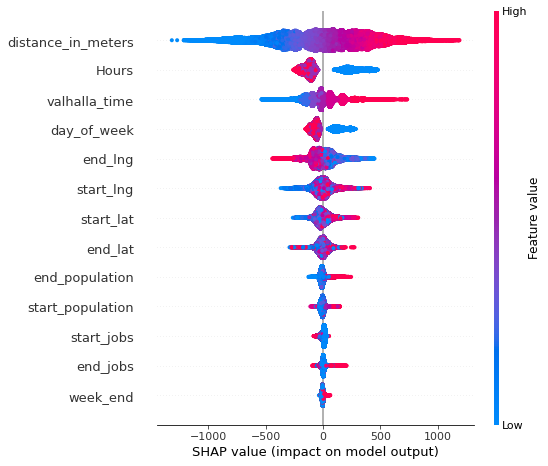

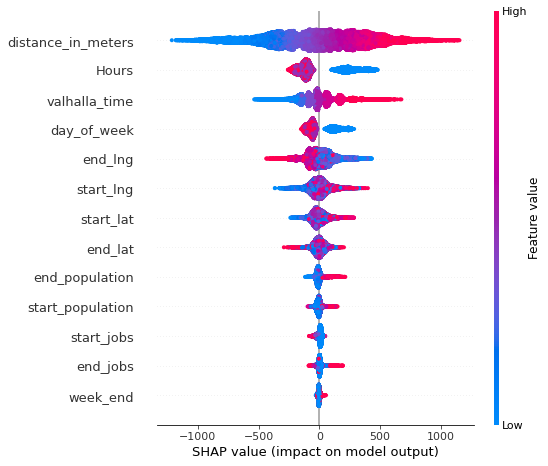

In [119]:
#Generating SHAP Summary Plots
shap.summary_plot(shap_cat_values_train, X_train, plot_type="dot")
shap.summary_plot(shap_cat_values_test, X_test, plot_type="dot")

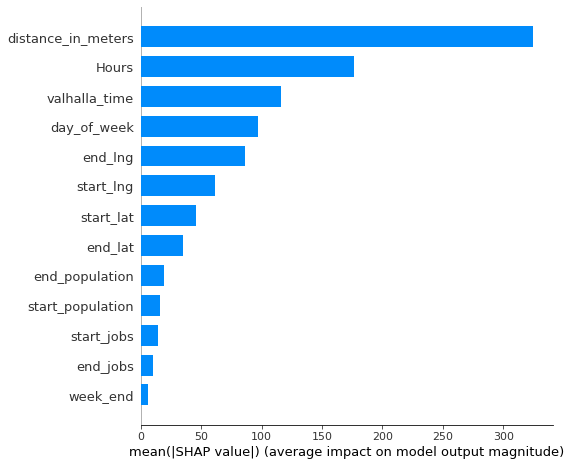

In [120]:
shap.summary_plot(shap_cat_values_test, X_test, plot_type="bar")

SHAP values estimate the impact of a feature on predictions whereas feature importances estimate the impact of a feature on model fit.

CatBoostRegressor's Feature Importance - The value that states how much importance of a specific feature. It doesn't tell you the elasticity of the feature rather it tell contribution in model building whereas shap values is nothing but elasticities of the features (It can be negative/positive ) but feature importance is always positive (sum =1, always)

#### From ``` shap_cat_values_train```
- feature distance_in_meters: high feature values correlate positively & low feature values correlate negatively with the target driving time in traffic;  the longer the distance, the more time it will take.
- feature hour: high values correlate negatively.this also makes sense, because 7 = 7am, 14 = 2pm, 23 = 11pm, Morning 7am is usually the peak time (weekend are just 2 days so it account less than the weekdays). 
- feature valhalla_time: high feature values correlate positively & low feature values correlate negatively; this makes sense, because the valhalla_time presents the driving time without traffic.
- feature day_of_week: low values correlate positively. 1 = Monday, 2 = Sunday, 3 = Thursday. We can find from the graph that 1 has the largest positive effect on the prediction, which is reasonable. Because the number of commuters is the highest on Mondays, people may choose to work from home on the latter days of week.
- feature end_population: high feature values correlate positively; the more people in the destination h3, the more time needed to go there, because there will be more people travel to this destination.
- feature start_population: high feature values correlate positively --> same logic as above, imagine on Monday mornings, there will be more people departing from this location.
